In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# cuda device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

GeForce GTX 860M


In [3]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [4]:
# MNIST dataset
data_root = './data'
train_dataset = torchvision.datasets.MNIST(root=data_root,
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=data_root,
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

9920512it [00:06, 1606031.60it/s]                                                                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 139815.25it/s]                                                                                


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:01, 962854.21it/s]                                                                              


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 47085.23it/s]                                                                                  


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
# make an iterator to train dataset
train_iter = iter(train_loader)
# get the first batch of images and their labels
dd1, dd2 = next(train_iter)

In [6]:
# image size is [100, 1, 28, 28], while label size is [100]
dd1.shape, dd2.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [7]:
# The 16th image
index = 15
# remove the channel dimension
bb = dd1[index].squeeze()

# the current image dimension (28, 28), the label is digit 4
bb.shape, dd2[index]

(torch.Size([28, 28]), tensor(2))

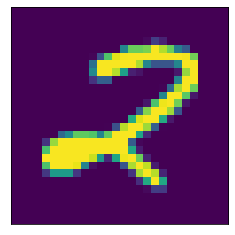

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

#
plt.imshow(bb)
plt.xticks([])
plt.yticks([]);

In [9]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # input shape: (None,1,28,28)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #output shape: (None,16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,16,14,14)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), #output shape: (None,32,14,14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,32,7,7)
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        # input shape: (None,1,28,28)
        out = self.layer1(x) #output shape: (None,16,14,14)
        out = self.layer2(out) #output shape: (None,32,7,7)
        """The reshape function also consider the 0th, i.e. batch dimension, different from Keras.Reshape!"""
        out = out.reshape(out.size(0), -1) #output shape: (None,32*7*7)
        out = self.fc(out) #output shape: (None,10)
        return out

model = ConvNet(num_classes).to(device)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        """PyTorch is channel first, different from TensorFlow!"""
        """images.size(): torch.Size([100, 1, 28, 28])"""
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.2036
Epoch [1/5], Step [200/600], Loss: 0.0700
Epoch [1/5], Step [300/600], Loss: 0.0557
Epoch [1/5], Step [400/600], Loss: 0.0662
Epoch [1/5], Step [500/600], Loss: 0.1829
Epoch [1/5], Step [600/600], Loss: 0.0575
Epoch [2/5], Step [100/600], Loss: 0.0218
Epoch [2/5], Step [200/600], Loss: 0.0131
Epoch [2/5], Step [300/600], Loss: 0.0769
Epoch [2/5], Step [400/600], Loss: 0.1182
Epoch [2/5], Step [500/600], Loss: 0.0752
Epoch [2/5], Step [600/600], Loss: 0.0426
Epoch [3/5], Step [100/600], Loss: 0.0839
Epoch [3/5], Step [200/600], Loss: 0.0045
Epoch [3/5], Step [300/600], Loss: 0.0285
Epoch [3/5], Step [400/600], Loss: 0.0178
Epoch [3/5], Step [500/600], Loss: 0.0145
Epoch [3/5], Step [600/600], Loss: 0.0703
Epoch [4/5], Step [100/600], Loss: 0.0421
Epoch [4/5], Step [200/600], Loss: 0.0271
Epoch [4/5], Step [300/600], Loss: 0.0196
Epoch [4/5], Step [400/600], Loss: 0.0328
Epoch [4/5], Step [500/600], Loss: 0.0341
Epoch [4/5], Step [600/600], Loss:

In [11]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
# has effect on specific layers like Dropout and BatchNorm
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #Tensor.data: tensor
        _, predicted = torch.max(outputs.data, 1)  # (None, 10)
        #Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        #Tensor.item(): number
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.95 %


In [12]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')